In [ ]:
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg
from keras.preprocessing import image
from numpy import linalg as LA
import os
import h5py
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#### 第一部分: 定义VGGNet 类，通过调用VGG16网络层可抽取图像特征

In [2]:
# 封装keras的Demo，定义类用于抽取图像特征：最后一层卷积层输出结果
class VGGNet:
    def __init__(self):
        self.input_shape = (224,224,3)
        self.weight = 'imagenet'
        self.pooling = 'max'
        self.model_vgg = VGG16(weights=self.weight,input_shape=(self.input_shape[0],self.input_shape[1],self.input_shape[2]),pooling=self.pooling,include_top=False)
        self.model_vgg.predict(np.zeros((1,224,224,3)))
    
    # 提取vgg16最后一层卷积特征
    def vgg_extract_feat(self,img_path):
        img = image.load_img(img_path,target_size = (self.input_shape[0],self.input_shape[1]))
        img = image.img_to_array(img)
        img = np.expand_dims(img,axis=0)
        img = preprocess_input_vgg(img)
        feat = self.model_vgg.predict(img)
        print(feat.shape)
        norm_feat = feat[0] / LA.norm(feat[0])
        return norm_feat

#### 第二部分：对图片数据库进行特征抽取，并存储至hdf5文件中：models/vgg_featureCNN.h5

In [3]:
# 定义函数用于获取文件夹下的文件名组成的列表
def get_imlist(path):
    import os
    name_list = [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg')]
    return name_list

In [4]:
# 定义函数用于构建训练流程
def train():
    database = 'pic/database/'
    index = 'models/vgg_featureCNN.h5'
    img_list = get_imlist(database)
    
    # 特征抽取开始
    print("--------------------------------------------")
    print("          features extraction starts        ")
    print("--------------------------------------------")
    
    # 收取图像数据的特征
    feats = []
    names = []
    
    model = VGGNet()
    # 遍历列表，抽取每个图像的特征
    for i, img_path in enumerate(img_list):
        norm_feat = model.vgg_extract_feat(img_path)
        img_name = os.path.split(img_path)[1]
        feats.append(norm_feat)
        names.append(img_name)
        print('extracting features from image No.%d ,%d images intotal ' %(i+1,len(img_list)))
        
    feats = np.array(feats) # 抽取特征后转换为array数组输出
    # 赋值至args数组
    output = index
    
    # 特征抽取结束
    print("--------------------------------------------")
    print("          features extraction ends          ")
    print("--------------------------------------------")
    
    # 转换成hdf5格式输出
    h5f = h5py.File(output,'w') # 创建文件
    h5f.create_dataset('dataset_1', data = feats)
    h5f.create_dataset('dataset_2', data = np.string_(names)) 
    h5f.close()

In [5]:
train()

--------------------------------------------
          features extraction starts        
--------------------------------------------


(1, 512)
extracting features from image No.1 ,6 images intotal 
(1, 512)
extracting features from image No.2 ,6 images intotal 
(1, 512)
extracting features from image No.3 ,6 images intotal 
(1, 512)
extracting features from image No.4 ,6 images intotal 
(1, 512)
extracting features from image No.5 ,6 images intotal 
(1, 512)
extracting features from image No.6 ,6 images intotal 
--------------------------------------------
          features extraction ends          
--------------------------------------------


#### 第三部分：对图片数据库进行特征抽取，并存储至hdf5文件中：models/vgg_featureCNN.h5

In [15]:
def query(query,result):
    # query = '1490569.jpg'
    index = 'models/vgg_featureCNN.h5'
    # result = 'pic'
    
    
    h5f = h5py.File(index,'r')
    feats = h5f['dataset_1'][:]

    imgNames = h5f['dataset_2'][:]
    h5f.close()

    print("--------------------------------------------")
    print("          searching starts          ")
    print("--------------------------------------------")

    # 读取输入的图片
    queryImg = mpimg.imread(query)
    plt.title("Query Image")
    plt.imshow(queryImg)
    plt.show()

    # 抽取输入图片的特征
    model = VGGNet()
    queryVec = model.vgg_extract_feat(query)
    scores = np.dot(queryVec,feats.T)
    rank_ID = np.argsort(scores)[::-1]
    rank_score = scores[rank_ID]

    maxres = 3
    imlist = []
    
    # 遍历 并获取相似度得分
    for i,index in enumerate(rank_ID[0:maxres]):
        imlist.append(imgNames[index])
        print("image names: " + str(imgNames[index]) + "scores: %f" %(rank_score[i]))

    print("top %d images in order are : %s" %(maxres, imlist))
    
    # 输出相似度排名maxres的图片
    for i, im in enumerate(imlist):
        result_path = result + '/' + str(im,'utf-8')
        # print(result_path)
        
        image = mpimg.imread(result_path)
        plt.title('search output %d ' %(i+1))
        plt.imshow(image)
        plt.show()
        print('图片%s 与输入图片的相似度为%.6f%%' %(str(im),rank_score[i]*100))


    print("--------------------------------------------")
    print("          searching ends          ")
    print("--------------------------------------------")

--------------------------------------------
          searching starts          
--------------------------------------------


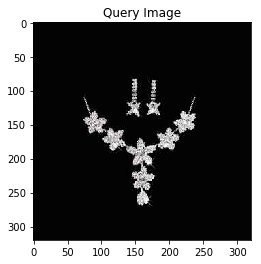

(1, 512)
image names: b'2003276.jpg'scores: 0.693209
image names: b'2552728.jpg'scores: 0.680157
image names: b'2961294.jpg'scores: 0.651960
top 3 images in order are : [b'2003276.jpg', b'2552728.jpg', b'2961294.jpg']


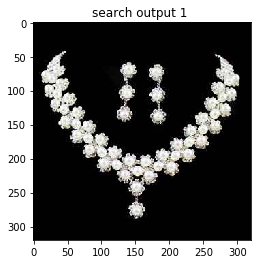

图片b'2003276.jpg' 与输入图片的相似度为69.320875%


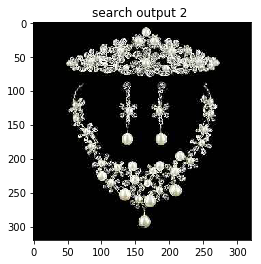

图片b'2552728.jpg' 与输入图片的相似度为68.015730%


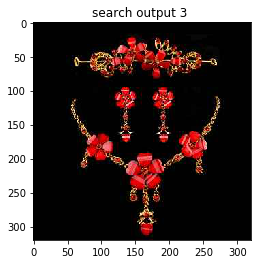

图片b'2961294.jpg' 与输入图片的相似度为65.195996%
--------------------------------------------
          searching ends          
--------------------------------------------


In [16]:
query('pic/query/885872.jpg','pic/database')